In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2018-11-13T00:00:00Z', '2018-11-14T00:00:00Z']

file_name = f"./data/psp_{time[0]}_{time[1]}_fit.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('PSP_SWP_SPC_L3I', ['vp_fit_RTN_gd', 'np_fit_gd'], time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = data.vp_fit_RTN.values
    velocity[np.any(velocity == data.vp_fit_RTN.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime))
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s")
    times = velocity.index.values
    velocity = velocity.values

    density = data.np_fit.values
    density[density == data.np_fit.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime))
    density = density.resample("60s").mean().shift(0.5, freq="60s").values

    status, data = cdas.get_data('PSP_FLD_L2_MAG_RTN', ['psp_fld_l2_mag_RTN'], time[0], time[1])

    magnetic_field = data.psp_fld_l2_mag_RTN.values
    magnetic_field[np.any(magnetic_field == data.psp_fld_l2_mag_RTN.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.epoch_mag_RTN.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime))
    magnetic_field = magnetic_field.resample("60s").mean().shift(0.5, freq="60s").values
    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 170)
gas_pressure = torch.zeros_like(density)
results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size_mb=4096,
                            window_steps=[max(duration // 16, 1) for duration in durations],
                            window_lengths=durations, min_strength=25, frame_type="vht")

100%|██████████| 160/160 [00:08<00:00, 18.33it/s]


2018-11-13T09:27:30.000000000  to  2018-11-13T12:05:30.000000000
duration: 159
error: 0.115
walen slope: 0.072
<B>: 28.1
Altitude/azimuth: 50 / 80


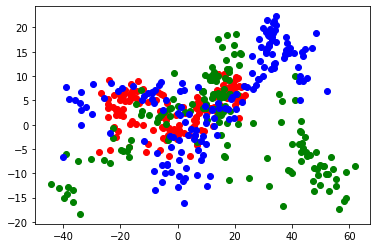

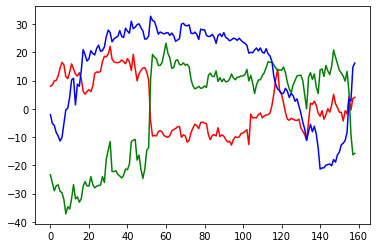

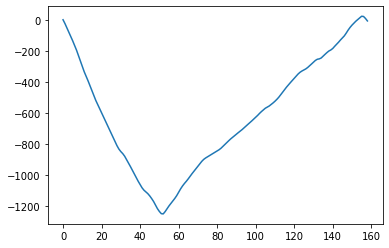

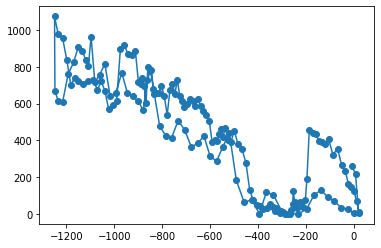

2018-11-13T23:12:30.000000000  to  2018-11-13T23:46:30.000000000
duration: 35
error: 0.119
walen slope: 0.3
<B>: 25.74
Altitude/azimuth: 35 / 290


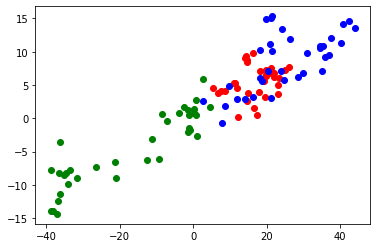

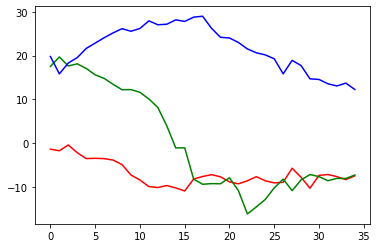

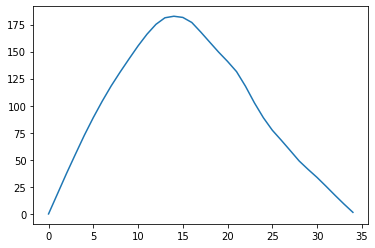

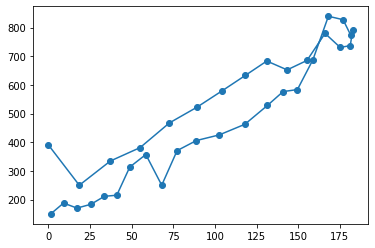

In [4]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for residue, start, end, duration, axis, frame, _ in results:
    z_unit = np.array(axis)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(residue, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))

    colors = ["red", "green", "blue"]

    for i_color, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
    plt.show()

    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = rotated[2] ** 2
    plt.scatter(A, P)
    plt.plot(A, P)
    plt.show()